# Data Analysis (OpenDatasus)

In [13]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import glob
import os

Variáveis

In [2]:
PATH_IN = '../raw/{}'
PATH_OUT = '../pre-processed/{}'
RESULTS = '../results/{}'

Function to check the existence of the path, if the path does not exist, it is created

- `path`: path to check or create

In [3]:
def sync_path(path: str) -> None:
    lvs = path.split('/')
    check = None
    for lv in range(1, len(lvs)+1):
        check = '/'.join(lvs[:lv])
        if not os.path.exists(check):
            os.mkdir(check)

Function to group the dataframe using the columns (`cols`)
- df: DataFrame to use
- cols: columns to group
- id_var: col id
- var_name: variables name

In [4]:
def grouped(
    df: pd.DataFrame,
    cols: [str],
    id_var: str,
    var_name: str,
    value_vars: {},
    value_name: str,
) -> pd.DataFrame:
    aux = pd.DataFrame([df[s].value_counts(dropna=False) for s in cols])
    aux.index.name = id_var
    aux.reset_index(inplace=True)
    aux.columns = aux.columns.fillna(-1)
    aux.rename(columns=value_vars, inplace=True)
    aux = pd.melt(
        aux,
        col_level=0,
        id_vars=[id_var],
        value_vars=value_vars.values(),
        var_name=var_name,
        value_name=value_name
    )
    return aux

Função para limpeza da base
- df: dataframe de entrada
- rules: regras de substituição `{index: {'cols': colunas, 'replaces': {value: new_value}}}` p.ex:
    - `{0: {'cols': 'SEXO', 'replaces': {None:0.0}}}`

In [89]:
def replace(df: pd.DataFrame, rules: {str:{}}) -> pd.DataFrame:    
    for rule in rules.values():
        cols = rule['cols']
        df[cols] = df[cols].replace(rule['replaces'])
    return df

## Pré-processamento e análise preliminar

Carregando o DataFrame do OpenDatasus
- df: utilizado para primeira execução
- df_filtered: dataframe com as etapas de preprocessamento já realizadas, executar as células a partir de `Análise exploratória`

In [5]:
df = pd.read_csv(
    PATH_IN.format('ODS/INFLUD-15-02-2021.csv.tar.gz'),
    low_memory=False,
    compression='gzip',
    encoding='latin',
    sep=';'
)
df

,INFLUD-15-02-2021.csv,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA
0,07/01/2020,2.0,03/01/2020,1.0,DF,NaN,NaN,BRASILIA,530010.0,HRT HOSPITAL REGIONAL DE TAGUATINGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13/02/2020,7.0,08/02/2020,6.0,SP,GVE XXXI SOROCABA,1353.0,SALTO,354520.0,HOSPITAL E MATERNIDADE MUNICIPAL N S DO MONTE ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/01/2020,5.0,26/01/2020,5.0,CE,1 CRES FORTALEZA,1519.0,FORTALEZA,230440.0,HIAS HOSPITAL INFANTIL ALBERT SABIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16/01/2020,3.0,10/01/2020,2.0,SP,GVE XXXIII TAUBATE,1352.0,TAUBATE,355410.0,HOSPITAL REGIONAL DO VALE DO PARAIBA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26/02/2020,9.0,24/02/2020,9.0,SP,GVE VII SANTO ANDRE,1332.0,MAUA,352940.0,SANTA CASA DE MAUA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178371,05/02/2021,5.0,01/01/2021,53.0,SP,GVE VII SANTO ANDRE,1332.0,SANTO ANDRE,354780.0,HOSPITAL E MATERNIDADE DR CHRISTOVAO DA GAMA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178372,24/12/2020,52.0,20/12/2020,52.0,RJ,NaN,NaN,BELFORD ROXO,330045.0,HOSPITAL MUNICIPAL DE BELFORD ROXO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178373,16/12/2020,51.0,06/12/2020,50.0,RJ,NaN,NaN,SAO GONCALO,330490.0,PRONTO SOCORRO CENTRAL DR ARMANDO GOMES DE SA ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178374,07/12/2020,50.0,07/12/2020,50.0,PE,001,1497.0,RECIFE,261160.0,HOSPITAL DA RESTAURACAO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verificando as colunas preexistentes

In [6]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178376 entries, 0 to 1178375
Data columns (total 154 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   INFLUD-15-02-2021.csv  1178375 non-null  object 
 1   SEM_NOT                1178375 non-null  float64
 2   DT_SIN_PRI             1178375 non-null  object 
 3   SEM_PRI                1178375 non-null  float64
 4   SG_UF_NOT              1178375 non-null  object 
 5   ID_REGIONA             1023692 non-null  object 
 6   CO_REGIONA             1023692 non-null  float64
 7   ID_MUNICIP             1178375 non-null  object 
 8   CO_MUN_NOT             1178375 non-null  float64
 9   ID_UNIDADE             1178375 non-null  object 
 10  CO_UNI_NOT             1178375 non-null  float64
 11  CS_SEXO                1178375 non-null  object 
 12  DT_NASC                1176109 non-null  object 
 13  NU_IDADE_N             1178375 non-null  float64
 14  TP_IDADE         

Desconsiderando algumas colunas:

In [7]:
path = PATH_OUT.format('ODS')
sync_path(path)

df_filtered = df.drop(columns=[
    'ID_REGIONA', # Nome Regional de Saúde onde está localizado o Município realizou a notificação
    'CO_REGIONA', # Código Regional de Saúde onde está localizado o Município realizou a notificação
    'CS_ETINIA', # Nome e código da etnia do paciente, quando indígena.
    'PAC_COCBO', # Nome Ocupação profissional do paciente
    'PAC_DSCBO', # Código Ocupação profissional do paciente
    'ID_RG_RESI', # Nome regional de Saúde onde está localizado o Município de residência do paciente
    'CO_RG_RESI', # Código regional de Saúde onde está localizado o Município de residência do paciente
    'PAIS_VGM', # Nome País onde foi realizada a viagem
    'CO_PS_VGM', # Código País onde foi realizada a viagem
    'LO_PS_VGM', # Local (cidade, estado, província e outros) onde foi realizada a viagem (internacional)
    'DT_VGM', # Data em que foi realizada a viagem (internacional)
    'DT_RT_VGM', # Data em que retornou de viagem (internacional)
    'OBES_IMC', # Valor do IMC (Índice de Massa Corporal) do paciente calculado pelo profissional de saúde.
    'DT_UT_DOSE', # Data da última dose de vacina contra a gripe
    'DT_VAC_MAE', # Se a mãe recebeu vacina, qual a data?
    'M_AMAMENTA', # Se paciente < 6 meses, a mãe amamenta a criança?
    'DT_DOSEUNI', # Se >= 6 meses e <= 8 anos, data da dose única para crianças vacinadas em campanhas de anos anteriores
    'DT_1_DOSE', # Se >= 6 meses e <= 8 anos, data da 1ª dose para crianças vacinadas pela primeira vez
    'DT_2_DOSE', # Se >= 6 meses e <= 8 anos data da 2ª dose
    'DT_ANTIVIR', # Data em que foi iniciado o tratamento com o antiviral
    'ID_RG_INTE', # Nome Regional de Saúde onde está localizado o Município de internação do paciente.
    'CO_RG_INTE', # Código Regional de Saúde onde está localizado o Município de internação do paciente.
    'DT_ENTUTI', # Data de entrada do paciente na unidade de Terapia intensiva (UTI)
    'DT_SAIDUTI', # Data em que o paciente saiu da Unidade de Terapia intensiva (UTI).
    'DT_RAIOX', # Se realizou RX de Tórax, especificar a data do exame.
    'AMOSTRA', # Foi realizado coleta de amostra para realização de teste diagnóstico?
    'TP_AMOSTRA', # Tipo da amostra clínica coletada para o teste diagnóstico.
    'OUT_AMOST', # Descrição do tipo da amostra clínica, caso diferente das listadas nas categorias do campo
    'DT_COLETA', # Data da coleta da amostra para realização do teste diagnóstico.
    'TP_FLU_AN', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para o tipo de Influenza
    'AN_VSR', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para VSR.
    'AN_PARA1', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para Parainfluenza 1.
    'AN_PARA2', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para Parainfluenza 2
    'AN_PARA3', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para Parainfluenza 3
    'AN_ADENO', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para Adenovírus
    'AN_OUTRO', # Resultado diagnóstico da IF/outro método que não seja Biologia Molecular que para Outro vírus respiratório.
    'DS_AN_OUT', # Nome do outro vírus respiratório identificado pela IF/outro método que não seja Biologia Molecular que.
    'PCR_RESUL', # Resultado do teste de RT-PCR/outro método por Biologia Molecular
    'DT_PCR', # Data do Resultado RTPCR/outro método por Biologia Molecular
    'TP_FLU_PCR', # Resultado diagnóstico do RT-PCR para o tipo de Influenza.
    'PCR_FLUASU', # Subtipo para Influenza A.
    'FLUASU_OUT', # Outro subtipo para Influenza A.
    'PCR_FLUBLI', # Linhagem para Influenza B.
    'FLUBLI_OUT', # Outra linhagem para Influenza B.
    'PCR_VSR', # Resultado diagnóstico do RT-PCR para (VSR).
    'PCR_PARA1', # Resultado diagnóstico do RT-PCR para Parainfluenza 1
    'PCR_PARA2', # Resultado diagnóstico do RT-PCR para Parainfluenza 2
    'PCR_PARA3', # Resultado diagnóstico do RT-PCR para Parainfluenza 3
    'PCR_PARA4', # Resultado diagnóstico do RT-PCR para Parainfluenza 4.
    'PCR_ADENO', # Resultado diagnóstico do RT-PCR para Adenovírus.
    'PCR_METAP', # Resultado diagnóstico do RT-PCR para Metapneumovírus.
    'PCR_BOCA', # Resultado diagnóstico do RT-PCR para Bocavírus
    'PCR_RINO', # Resultado diagnóstico do RT-PCR para Rinovírus.
    'PCR_OUTRO', # Resultado diagnóstico do RT-PCR para Outro vírus respiratório.
    'DS_PCR_OUT', # Nome do outro vírus respiratório identificado pelo RTPCR.
    'INFLUD-15-02-2021.csv',
    'SEM_NOT',
    'DT_SIN_PRI',
    'SEM_PRI',
    'SG_UF_NOT',
    'ID_MUNICIP',
    'CO_MUN_NOT',
    'ID_UNIDADE',
    'CO_UNI_NOT',
    'COD_IDADE',
    'CS_GESTANT',
    'CS_RACA',
    'CS_ESCOL_N',
    'ID_PAIS',
    'CO_PAIS',
    'SG_UF',
    'ID_MN_RESI',
    'CO_MUN_RES',
    'CS_ZONA',
    'SURTO_SG',
    'NOSOCOMIAL',
    'AVE_SUINO',
    'MAE_VAC',
    'TP_ANTIVIR',
    'OUT_ANTIV',
    'HOSPITAL',
    'DT_INTERNA',
    'SG_UF_INTE',
    'ID_MN_INTE',
    'CO_MU_INTE',
    'UTI',
    'SUPORT_VEN',
    'RAIOX_RES',
    'RAIOX_OUT',
    'POS_PCRFLU',
    'POS_PCROUT',
    'CLASSI_OUT',
    'CRITERIO',
    'DT_EVOLUCA',
    'DT_ENCERRA',
    'DT_DIGITA',
    'PCR_SARS2',
    'OUT_ANIM',
    
    'TOMO_RES',
    'TOMO_OUT',
    'DT_TOMO',
    'TP_TES_AN',
    'DT_RES_AN',
    'RES_AN',
    'POS_AN_FLU',
    'POS_AN_OUT',
    'AN_SARS2',
    'TP_AM_SOR',
    'SOR_OUT',
    'DT_CO_SOR',
    'TP_SOR',
    'OUT_SOR',
    'DT_RES',
    'RES_IGG',
    'RES_IGM',
    'RES_IGA',
])
df_filtered.to_csv(f'{path}/INFLUD.csv.gz', index=False, compression='gzip')
df_filtered

,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,...,MORB_DESC,VACINA,ANTIVIRAL,CLASSI_FIN,EVOLUCAO,HISTO_VGM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA
0,M,08/06/2018,1.0,3.0,1.0,1.0,2.0,9.0,1.0,1.0,...,NaN,1.0,2.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN
1,F,01/05/1962,57.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,...,NaN,9.0,1.0,4.0,2.0,0.0,NaN,NaN,NaN,NaN
2,M,05/04/2019,9.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,...,NaN,NaN,1.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN
3,M,14/11/2018,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,...,NaN,2.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,F,07/07/1991,28.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,...,NaN,1.0,2.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178371,F,31/07/2017,3.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,...,NaN,2.0,2.0,NaN,NaN,9.0,2.0,2.0,2.0,2.0
1178372,F,11/04/1952,68.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,...,NaN,1.0,2.0,5.0,2.0,9.0,9.0,9.0,9.0,9.0
1178373,M,10/04/1926,94.0,3.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,9.0,2.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN
1178374,M,08/05/1968,52.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


Verificando a estrutura após filtro

In [8]:
df_filtered.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178376 entries, 0 to 1178375
Data columns (total 38 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   CS_SEXO     1178375 non-null  object 
 1   DT_NASC     1176109 non-null  object 
 2   NU_IDADE_N  1178375 non-null  float64
 3   TP_IDADE    1178375 non-null  float64
 4   FEBRE       1022279 non-null  float64
 5   TOSSE       1046887 non-null  float64
 6   GARGANTA    886185 non-null   float64
 7   DISPNEIA    1045768 non-null  float64
 8   DESC_RESP   984535 non-null   float64
 9   SATURACAO   990748 non-null   float64
 10  DIARREIA    873660 non-null   float64
 11  VOMITO      862636 non-null   float64
 12  OUTRO_SIN   871316 non-null   float64
 13  OUTRO_DES   367668 non-null   object 
 14  PUERPERA    473088 non-null   float64
 15  FATOR_RISC  1178375 non-null  object 
 16  CARDIOPATI  609166 non-null   float64
 17  HEMATOLOGI  477150 non-null   float64
 18  SIND_DOWN   475065 non

Verificando valores ausentes (base filtrada) - Matrix

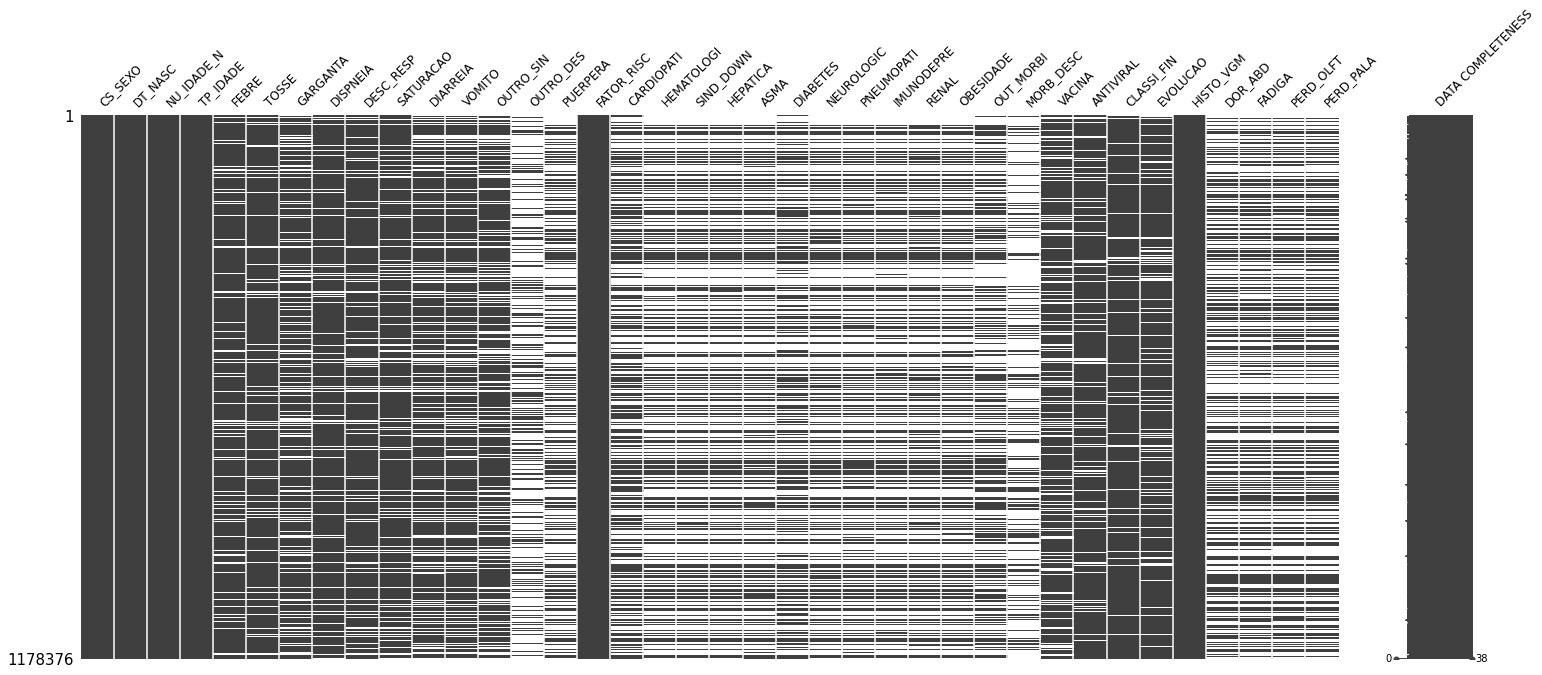

In [10]:
path = RESULTS.format('ODS/missingno')
fig = msno.matrix(df_filtered, labels=True, fontsize=12)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{path}/matrix.png')

Verificando valores ausentes (base filtrada) - Bar

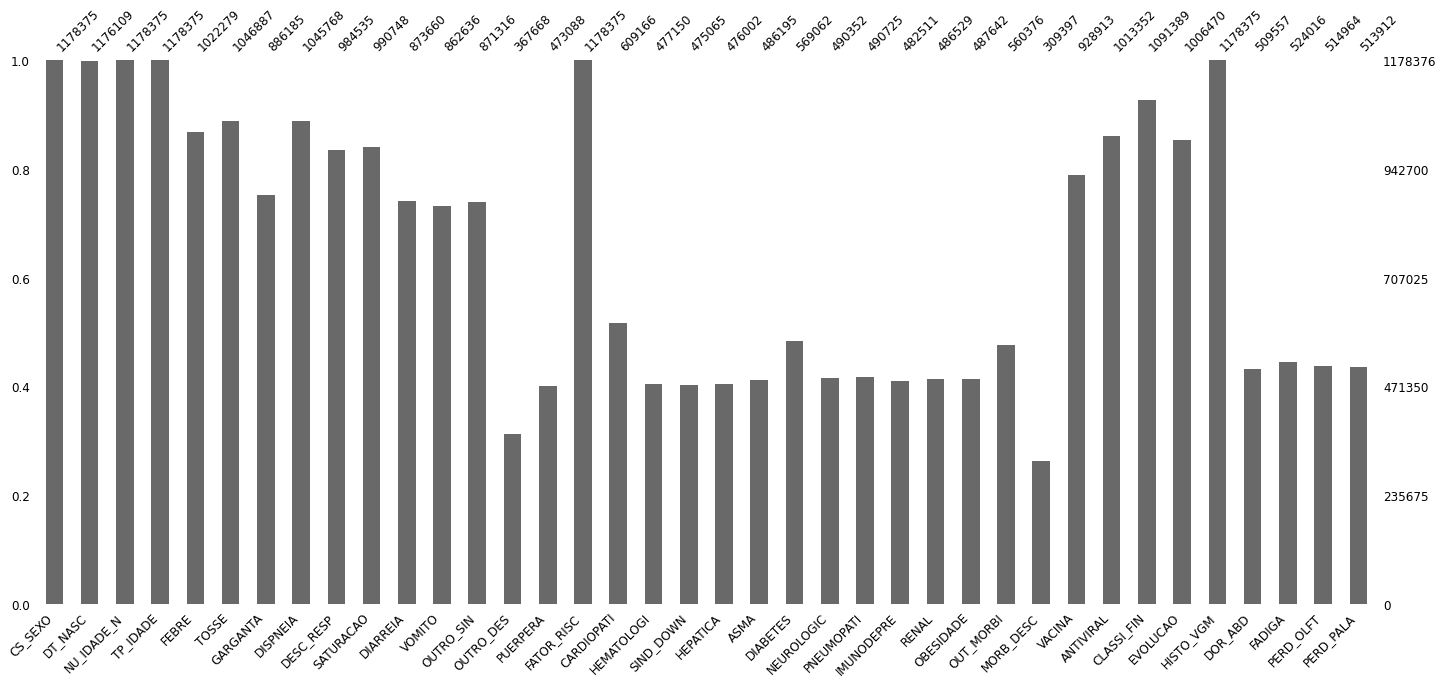

In [11]:
path = RESULTS.format('ODS/missingno')
fig = msno.bar(df_filtered, labels=True, fontsize=12)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{path}/bar.png')

Classificação da base

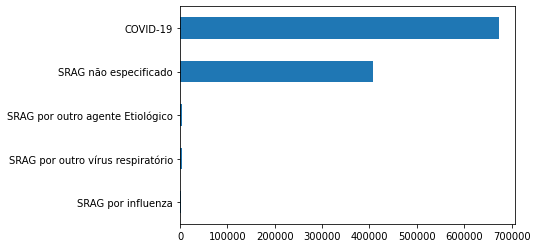

In [16]:
path = RESULTS.format('ODS')
sync_path(path)
df_class = df_filtered.groupby('CLASSI_FIN').size()
df_class.index = [
    'SRAG por influenza',
    'SRAG por outro vírus respiratório',
    'SRAG por outro agente Etiológico',
    'SRAG não especificado',
    'COVID-19',
]
df_class.plot(kind='barh')
plt.savefig(f'{path}/bar_class.png')

---

## Tentativa de concatenação com as defasagens para enriquecimento

Variáveis de interesse:
- Sintomas
- Comorbidades
- Sexo
- Idade
- Classificação
- Evolução

In [51]:
symptoms = [
    'FEBRE',
    'TOSSE',
    'GARGANTA',
    'DISPNEIA',
    'DESC_RESP',
    'SATURACAO',
    'DIARREIA',
    'VOMITO', #
    
    'DOR_ABD',
    'FADIGA',
    'PERD_OLFT',
    'PERD_PALA',

#     'OUTRO_SIN',
#     'OUTRO_DES',
]

comorbidities = [
    'PUERPERA',
    'CARDIOPATI',
    'HEMATOLOGI', #
    'SIND_DOWN',
    'HEPATICA',
    'ASMA', #
    'DIABETES', #
    'NEUROLOGIC',
    'PNEUMOPATI',
    'IMUNODEPRE',
    'RENAL',
    'OBESIDADE',
#     'OUT_MORBI',
#     'MORB_DESC',
]

interest_cols = [
    *symptoms,
    *comorbidities,
    'CS_SEXO',

    'FATOR_RISC',
#     'VACINA',
#     'ANTIVIRAL',
#     'HISTO_VGM',

    'TP_IDADE', #
    'NU_IDADE_N',
    'CLASSI_FIN',
    'EVOLUCAO',
]

Listando dataframes

In [52]:
files = glob.glob(PATH_IN.format('ODS/*.csv.tar.gz'))
files

['../raw/ODS/INFLUD-15-02-2021.csv.tar.gz',
 '../raw/ODS/INFLUD21-15-02-2021.csv.tar.gz']

Verificando ausência das colunas de interesse nas defasagens

In [53]:
for file in files:
    df = pd.read_csv(
        file,
        low_memory=False,
        compression='gzip',
        encoding='latin',
        sep=';'
    )
    cols = set(df.columns)
    icols = set(interest_cols)
    print(f'{file}: {icols.difference(cols)}')

../raw/ODS/INFLUD-15-02-2021.csv.tar.gz: set()
../raw/ODS/INFLUD21-15-02-2021.csv.tar.gz: set()


Gerando dataset 2020-2021

In [54]:
df = pd.DataFrame()
for file in files[-2:]:
    aux = pd.read_csv(
        file,
        low_memory=False,
        compression='gzip',
        encoding='latin',
        sep=';',
        usecols=interest_cols,
    )
    df = pd.concat([df, aux], sort=False)

df.to_csv(PATH_OUT.format('ODS/20-21.csv.gz'), index=False, compression='gzip')

In [55]:
df

,CS_SEXO,NU_IDADE_N,TP_IDADE,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,...,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA
0,M,1.0,3.0,1.0,1.0,2.0,9.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN
1,F,57.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,2.0,2.0,2.0,2.0,4.0,2.0,NaN,NaN,NaN,NaN
2,M,9.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN
3,M,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,28.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129471,M,72.0,3.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN
129472,M,50.0,3.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,5.0,NaN,2.0,2.0,2.0,2.0
129473,M,77.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,...,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0
129474,M,26.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0


Verificando os campos de comorbidades onde fator de risco = N

In [56]:
df.loc[df['FATOR_RISC'] == 'N', [*comorbidities]].count()

PUERPERA      0
CARDIOPATI    0
HEMATOLOGI    0
SIND_DOWN     0
HEPATICA      0
ASMA          0
DIABETES      0
NEUROLOGIC    0
PNEUMOPATI    0
IMUNODEPRE    0
RENAL         0
OBESIDADE     0
dtype: int64

Adicionando comorbidades com 'Não (2)' quando fator de risco = N

In [57]:
df.loc[df['FATOR_RISC'] == 'N', [*comorbidities]] = 2.0

Adicionando idade como '0' a todos os menores que 1 ano

In [78]:
df.loc[df['TP_IDADE'].isin([1,2]), 'NU_IDADE_N'] = 0

Removendo as colunas não utilizadas

In [86]:
df.drop(columns=['TP_IDADE', 'FATOR_RISC'], inplace=True)

Removendo tuplas que contenham apenas nans

In [101]:
df.dropna(how='all', inplace=True)

Regras para replace

In [112]:
df['CS_SEXO'].unique()

array([1., 2., 9.])

In [107]:
rules = {}
rules.update({0: {'cols': [*symptoms, *comorbidities], 'replaces': {None: 0.}}})
rules.update({1: {'cols': 'CS_SEXO', 'replaces': {'M':1., 'F':2., 'I':9.}}})
rules.update({2: {'cols': 'CLASSI_FIN', 'replaces': {5.:1., 4.:0., 3.:0., 2.:0., 1.:0.}}})

df = replace(df, rules)

In [113]:
df.to_csv(PATH_OUT.format('ODS/20-21.csv.gz'), index=False, compression='gzip')